In [ ]:
# default_exp core

# 01 Prodb Benchmarks

> Which database is faster? The highly optimised SQLAlchemy library, or the library that literally saves and loads the entire csv every time you modify it?

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
import pandas as pd
import arrow
import os
from time import gmtime, strftime
import sys; sys.path.append('../')
from prodb.core import generate_db, insert_row, insert_rows, utc_now, readable_df

# 1. Prodb API Benchmarks

In [ ]:
# ================================================================ #
data = {'name': ['Sam', 'Grant'],
        'mood': ['😊', '😵'],
        'message': ['hello from London, UK', 'hello from Christchurch, NZ'],
        'time_utc' : [utc_now(), utc_now()]}
# ================================================================ #

Duration to insert, append, save, and reload the dataframe 100 times.

In [ ]:
%%time

def test_prodb(n=1, verbose=True):
    dbpath='benchmarks/prodb.csv'
    df = generate_db(dbpath=dbpath, cols='name mood message'.split(), verbose=verbose)
    for i in range(n):
        df = insert_rows(df, data, dbpath=dbpath)   # save to disk
        df = pd.read_csv(dbpath)                    # load from disk
    return df

df = test_prodb(n=100)
print(df.shape)
display(df.tail())

✓💾 benchmarks/prodb.csv (19 kb)
(200, 4)


,name,mood,message,time_utc
195,Grant,😵,"hello from Christchurch, NZ",2021-11-12 16:29:24
196,Sam,😊,"hello from London, UK",2021-11-12 16:29:24
197,Grant,😵,"hello from Christchurch, NZ",2021-11-12 16:29:24
198,Sam,😊,"hello from London, UK",2021-11-12 16:29:24
199,Grant,😵,"hello from Christchurch, NZ",2021-11-12 16:29:24


Wall time: 213 ms


#### Reading and writing time of small `csv`

In [ ]:
df.shape

(200, 4)

In [ ]:
%%timeit
df.to_csv('benchmarks/tmp.csv')

944 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
df = pd.read_csv('benchmarks/tmp.csv')

923 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
df.iloc[50, :]

46.6 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# 2.  SQLModel / SQLAlchemy Benchmarks
`SQLModel` code and functions from [lukexyz/sqlmodel-streamlit/app.py](https://github.com/lukexyz/sqlmodel-streamlit/blob/main/app.py)

In [ ]:
#!pip install sqlmodel

In [ ]:
from sqlmodel import Field, Session, SQLModel, create_engine, select
from typing import Optional

import logging, sys
logging.disable(sys.maxsize)


class Hero(SQLModel, table=True):
    __table_args__ = {'extend_existing': True}  # required for streamlit refreshing
    id: Optional[int] = Field(default=None, primary_key=True)
    name: str
    secret_name: str
    age: Optional[int] = None

def create_db_and_tables():
    SQLModel.metadata.create_all(engine)

def get_table():
    with Session(engine) as session:
        heroes = session.exec(select(Hero)).all()
        return pd.DataFrame([s.dict() for s in heroes])

def delete_db():
    with Session(engine) as session:
        heroes = session.exec(select(Hero)).all()
        for hero in heroes:
            session.delete(hero)  
        session.commit()  

def commit_new_row():
    hero = Hero(name='Luke', secret_name='Luke Woods', age=23)
    hero_1 = Hero(name="Rusty-Man", secret_name="Tommy Sharp", age=36)
    with Session(engine) as session:
        session.add(hero)
        session.add(hero_1)
        session.commit()

#### Create engine

In [ ]:
sqlite_file_name = 'sqlmodel.db'
sqlite_url = f"sqlite:///{sqlite_file_name}"
engine = create_engine(sqlite_url, echo=True)

In [ ]:
delete_db()
create_db_and_tables()
commit_new_row()
get_table()

,secret_name,age,id,name
0,Luke Woods,23,1,Luke
1,Tommy Sharp,36,2,Rusty-Man


### Run 100 iteration benchmark

In [ ]:
%%time
delete_db()
create_db_and_tables()
    
def test_sqlmodel(n=100):
    for k in range(n):
        commit_new_row()  # add two rows to db
    return get_table()
    
df = test_sqlmodel(n=100)
print(df.shape)
df.tail()

(200, 4)
Wall time: 576 ms


,secret_name,age,id,name
195,Tommy Sharp,36,196,Rusty-Man
196,Luke Woods,23,197,Luke
197,Tommy Sharp,36,198,Rusty-Man
198,Luke Woods,23,199,Luke
199,Tommy Sharp,36,200,Rusty-Man


# SQLAlchemy
* Good code from the good man Jesse Jcharis on [github](https://github.com/Jcharis/streamlit_todo_crud_app/blob/main/db_fxns.py)

In [ ]:
#!pip install sqlalchemy

In [ ]:
import pandas as pd
import json
import sqlite3

In [ ]:
conn = sqlite3.connect('benchmarks/sqlite.db',check_same_thread=False)
c = conn.cursor()

def create_table():
    c.execute('CREATE TABLE IF NOT EXISTS taskstable(name TEXT,mood TEXT,message TEXT)')

def add_data(name,mood,message):
    c.execute('INSERT INTO taskstable(name,mood,message) VALUES (?,?,?)',(name,mood,message))
    conn.commit()
    
def view_all_data():
    c.execute('SELECT * FROM taskstable')
    data = c.fetchall()
    return data

def empty_table(name):
    c.execute('DELETE FROM taskstable WHERE name="{}"'.format(name))
    conn.commit()

In [ ]:
create_table()

name = "Luke"
mood = "👍"
message = "An SQLite database entry"

empty_table(name)
add_data(name, mood, message)

In [ ]:
ds = pd.DataFrame(view_all_data(), columns=['name', 'mood', 'message'])
print(ds.shape)
ds.tail()

(1, 3)


,name,mood,message
0,Luke,👍,An SQLite database entry


### `SQLAlchemy` 100 commits benchmark

In [ ]:
%%time
def test_sqlalchemy(n=100):
    for i in range(n):
        add_data(name, mood, message)
    res = view_all_data()

test_sqlalchemy(n=100)

Wall time: 392 ms


# Benchmark Comparisons

In [ ]:
#!pip install tqdm

In [ ]:
from tqdm.notebook import tqdm
from utils.timer import Timer

### 1. Prodb

In [ ]:
_t = {'prodb': Timer()}
test_range = range(1, 1002, 50)
commits = []
time = []
for i in tqdm(list(test_range)):
    _t['prodb'].tic()
    dt = test_prodb(n=i, verbose=False)
    time.append(1000*round(_t['prodb'].toc(), 4))
    commits.append(dt.shape[0])

dx = pd.DataFrame()
dx['commits'] = commits
dx['prodb_ms'] = time

  0%|          | 0/21 [00:00<?, ?it/s]

### 2. SQLModel

In [ ]:
commits = []
time = []

for i in tqdm(list(test_range)):
    _t = {'db': Timer()}
    _t['db'].tic()
    test_sqlmodel(n=i)
    time.append(1000*round(_t['db'].toc(), 4))
    commits.append(i+1)

dx['sqlmodel_ms'] = time

  0%|          | 0/21 [00:00<?, ?it/s]

### 3. SQLAlchemy

In [ ]:
commits = []
time = []

for i in tqdm(list(test_range)):
    _t = {'db': Timer()}
    _t['db'].tic()
    test_sqlalchemy(n=i)
    time.append(1000*round(_t['db'].toc(), 4))
    commits.append(i+1)

dx['sqlalchemy_ms'] = time

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
# benchmark dataset
dx.head()

,commits,prodb_ms,sqlmodel_ms,sqlalchemy_ms
0,2,7.0,133.1,11.0
1,102,58.0,420.4,235.0
2,202,106.4,763.0,443.0
3,302,159.0,1089.9,656.6
4,402,220.2,1540.4,846.3


# Plot Results

In [ ]:
#!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='commits'>

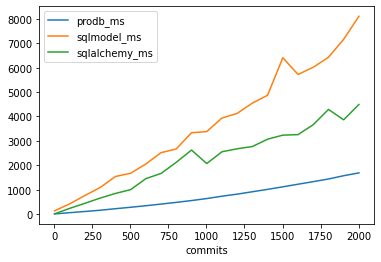

In [ ]:
dx.set_index('commits').plot.line()